In [208]:
import numpy as np
from dataclasses import dataclass
from typing import Tuple

# =========================
# Heston + Carr–Madan (FFT)
# =========================

@dataclass(frozen=True)
class HestonParams:
    kappa: float
    theta: float
    sigma: float
    rho: float
    v0: float

def heston_cf(u: np.ndarray, T: float, S0: float, r: float, q: float, p: HestonParams) -> np.ndarray:
    """
    Characteristic function φ(u) = E_Q[exp(i u ln S_T)].
    Little Heston Trap parametrization. Vectorized in u.
    """
    u = np.asarray(u, dtype=np.complex128)
    i = 1j
    x0 = np.log(S0)

    # Parameters
    a = p.kappa * p.theta
    b = p.kappa - p.rho * p.sigma * i * u
    d = np.sqrt(b*b + (p.sigma**2) * (i*u + u*u))  # sqrt(b^2 + σ^2(u^2 + i u))
    g = (b - d) / (b + d)                           # |g|<1 in the "little trap" branch

    eDT = np.exp(-d * T)
    one_minus_g_eDT = 1 - g * eDT
    one_minus_g     = 1 - g

    # Numerical guards
    eps = 1e-15
    one_minus_g_eDT = np.where(np.abs(one_minus_g_eDT) < eps, eps, one_minus_g_eDT)
    one_minus_g     = np.where(np.abs(one_minus_g)     < eps, eps, one_minus_g)

    C = i*u*(r - q)*T + (a/(p.sigma**2)) * ((b - d)*T - 2.0*np.log(one_minus_g_eDT/one_minus_g))
    D = ((b - d)/(p.sigma**2)) * ((1.0 - eDT) / one_minus_g_eDT)
    return np.exp(C + D*p.v0 + i*u*x0)

def _simpson_weights(N: int) -> np.ndarray:
    """Simpson weights on an N-point uniform grid (N must be even)."""
    if N % 2 != 0:
        raise ValueError("N must be even for Simpson weights.")
    w = np.ones(N)
    w[1:N-1:2] = 4.0
    w[2:N-2:2] = 2.0
    return w

def heston_fft_calls(
    S0: float,
    T: float,
    r: float,
    q: float,
    p: HestonParams,
    N: int = 4096,         # even, power of two preferred
    eta: float = 0.25,     # frequency step Δv > 0
    alpha: float = 1.5,    # damping > 0
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Carr–Madan FFT for call prices across a log-strike grid k = ln K.
    Returns K (ascending) and C(K).
    """
    if N <= 0 or N % 2:
        raise ValueError("N must be a positive even integer.")
    if eta <= 0:
        raise ValueError("eta must be > 0.")
    if alpha <= 0:
        raise ValueError("alpha must be > 0.")

    i = 1j
    n = np.arange(N)
    v = eta * n  # frequency grid v_n = n Δv, includes 0

    # ψ(v) = e^{-rT} φ(v - i(α+1)) / [(α + iv)(α + iv + 1)]
    u_shift = v - (alpha + 1.0)*i
    phi_shift = heston_cf(u_shift, T, S0, r, q, p)

    denom = (alpha**2 + alpha - v**2 + i*(2*alpha + 1.0)*v)  # (α+iv)(α+iv+1)
    # guard at v=0 is unnecessary if alpha>0, but keep tiny floor
    denom = np.where(np.abs(denom) < 1e-15, 1e-15, denom)

    psi = np.exp(-r*T) * phi_shift / denom

    # Simpson weights for the v-integral
    w = _simpson_weights(N) * (eta / 3.0)

    # FFT coupling: k-grid spacing and shift
    lam = 2.0 * np.pi / (N * eta)   # Δk
    b   = 0.5 * N * lam             # half-width in k; k_j = -b + j Δk
    x   = psi * np.exp(1j * b * v) * w

    F   = np.fft.fft(x)
    F   = np.real(F)  # imaginary residuals are numerical noise

    j = np.arange(N)
    k = -b + j * lam                 # k = ln K
    K = np.exp(k)

    calls = np.exp(-alpha * k) / np.pi * F
    order = np.argsort(K)
    return K[order], np.maximum(calls[order], 0.0)

def heston_fft_call_price(
    S0: float, K: float, T: float, r: float, q: float, p: HestonParams,
    N: int = 4096, eta: float = 0.25, alpha: float = 1.5
) -> float:
    """Price a single call via FFT + monotone linear interpolation on K."""
    K_grid, C_grid = heston_fft_calls(S0, T, r, q, p, N=N, eta=eta, alpha=alpha)
    # clamp or interpolate
    if K <= K_grid[0]:
        return float(C_grid[0])
    if K >= K_grid[-1]:
        return float(C_grid[-1])
    idx = int(np.searchsorted(K_grid, K))
    x0, x1 = K_grid[idx-1], K_grid[idx]
    y0, y1 = C_grid[idx-1], C_grid[idx]
    w = (K - x0) / (x1 - x0)
    return float(y0 + w * (y1 - y0))

def heston_fft_put_price(
    S0: float, K: float, T: float, r: float, q: float, p: HestonParams,
    N: int = 4096, eta: float = 0.25, alpha: float = 1.5
) -> float:
    """Put via put–call parity."""
    C = heston_fft_call_price(S0, K, T, r, q, p, N=N, eta=eta, alpha=alpha)
    return float(C - S0*np.exp(-q*T) + K*np.exp(-r*T))


In [209]:
# parameters
S0, r, q, T = 100.0, 0.01, 0.00, 1.0
hp = HestonParams(kappa=1.5, theta=0.04, sigma=0.3, rho=-0.7, v0=0.04)

# full grid of calls
K, C = heston_fft_calls(S0, T, r, q, hp, N=4096, eta=0.25, alpha=1.5)

# single strikes
call_100 = heston_fft_call_price(S0, 100, T, r, q, hp)

call_100

8.07774347291964

In [210]:
# Simulate Heston price with given parameters
S0 = 100          # Initial stock price
K = 100           # Strike price
T = 1             # Time to maturity
r = 0.01          # Risk-free rate
v0 = 0.04         # Initial variance
kappa = 2         # Mean reversion speed
theta = 0.04      # Long-run variance
sigma = 0.3       # Volatility of variance
rho = -0.7        # Correlation
N = 16384         # Number of grid points
alpha = 1.5       # Damping factor

# Simulation parameters
n_paths = 10000   # Number of paths
n_steps = 252     # Number of time steps (daily)
dt = T/n_steps    # Time step size

# Initialize arrays for paths
S = np.zeros((n_paths, n_steps + 1))
v = np.zeros((n_paths, n_steps + 1))

# Set initial values
S[:, 0] = S0
v[:, 0] = v0

# Generate correlated random numbers
rng = np.random.default_rng()
dW1 = rng.normal(0, np.sqrt(dt), (n_paths, n_steps))
dW2 = rho * dW1 + np.sqrt(1 - rho**2) * rng.normal(0, np.sqrt(dt), (n_paths, n_steps))

# Euler-Maruyama simulation
for t in range(n_steps):
    # Ensure variance stays positive
    v[:, t] = np.maximum(v[:, t], 0)

    # Update stock price
    S[:, t+1] = S[:, t] * np.exp((r - 0.5*v[:, t])*dt + np.sqrt(v[:, t])*dW1[:, t])

    # Update variance
    v[:, t+1] = v[:, t] + kappa*(theta - v[:, t])*dt + sigma*np.sqrt(v[:, t])*dW2[:, t]

# Calculate call option prices
payoffs = np.maximum(S[:, -1] - K, 0)
discounted_payoffs = np.exp(-r*T) * payoffs
price = np.mean(discounted_payoffs)

# Calculate 95% confidence interval
std_error = np.std(discounted_payoffs) / np.sqrt(n_paths)
ci_lower = price - 1.96 * std_error
ci_upper = price + 1.96 * std_error

print(f"Heston call option price: {price:.8f}")
print(f"95% Confidence Interval: [{ci_lower:.8f}, {ci_upper:.8f}]")


Heston call option price: 8.08855678
95% Confidence Interval: [7.87571418, 8.30139938]


In [211]:
# Generate strike grid centered around S0
strikes = np.arange(S0-20, S0+25, 5)

# Get FFT prices for all strikes
K_fft, C_fft = heston_fft_calls(S0, T, r, q, hp, N=4096, eta=0.25, alpha=1.5)

# Interpolate FFT prices to our strike grid
fft_prices = np.interp(strikes, K_fft, C_fft)

# Calculate MC prices for all strikes
mc_prices = []
mc_ci_lower = []
mc_ci_upper = []

for K in strikes:
    payoffs = np.maximum(S[:, -1] - K, 0)
    discounted_payoffs = np.exp(-r*T) * payoffs
    price = np.mean(discounted_payoffs)

    # Calculate 95% confidence interval
    std_error = np.std(discounted_payoffs) / np.sqrt(n_paths)
    mc_prices.append(price)
    mc_ci_lower.append(price - 1.96 * std_error)
    mc_ci_upper.append(price + 1.96 * std_error)

# Print comparison table
print("\nPrice Comparison:")
print("Strike   FFT Price   MC Price   MC 95% CI")
print("-" * 45)
for i in range(len(strikes)):
    print(f"{strikes[i]:6.1f}   {fft_prices[i]:9.4f}   {mc_prices[i]:8.4f}   [{mc_ci_lower[i]:8.4f}, {mc_ci_upper[i]:8.4f}]")


Price Comparison:
Strike   FFT Price   MC Price   MC 95% CI
---------------------------------------------
  80.0     22.3804    22.3144   [ 21.9945,  22.6344]
  85.0     18.2617    18.2018   [ 17.9028,  18.5008]
  90.0     14.4595    14.4024   [ 14.1283,  14.6765]
  95.0     11.0425    11.0132   [ 10.7682,  11.2582]
 100.0      8.0777     8.0886   [  7.8757,   8.3014]
 105.0      5.6161     5.6678   [  5.4887,   5.8470]
 110.0      3.6817     3.7625   [  3.6168,   3.9082]
 115.0      2.2629     2.3608   [  2.2466,   2.4750]
 120.0      1.2993     1.3949   [  1.3088,   1.4810]


In [212]:

import numpy as np
import math

def compute_iv_surface(price_fn, S0, strikes, maturities, r=0.0, q=0.0, params=None,
                       tol=1e-8, max_iter=100):
    """
    Invert model call prices to Black–Scholes implied vols on a (T,K) grid.
    price_fn must have signature: price_fn(S0, K, T, r, q, params) -> call price
    """
    Ks = np.asarray(list(strikes), dtype=float)
    Ts = np.asarray(list(maturities), dtype=float)
    iv  = np.empty((Ts.size, Ks.size), dtype=float)
    prc = np.empty_like(iv)

    def norm_cdf(x):
        return 0.5*(1.0 + math.erf(x/math.sqrt(2.0)))

    def bs_call_price(S0, K, T, r, q, vol):
        if T <= 0 or vol <= 0:
            return max(0.0, S0*math.exp(-q*T) - K*math.exp(-r*T))
        d1 = (math.log(S0/K) + (r - q + 0.5*vol*vol)*T) / (vol*math.sqrt(T))
        d2 = d1 - vol*math.sqrt(T)
        return S0*math.exp(-q*T)*norm_cdf(d1) - K*math.exp(-r*T)*norm_cdf(d2)

    def implied_vol_call(price, S0, K, T, r, q):
        low, high = 1e-6, 5.0
        intrinsic = max(0.0, S0*math.exp(-q*T) - K*math.exp(-r*T))
        cap = S0*math.exp(-q*T)
        price = min(max(price, intrinsic), cap - 1e-14)
        f_low  = bs_call_price(S0, K, T, r, q, low)  - price
        f_high = bs_call_price(S0, K, T, r, q, high) - price
        if f_low * f_high > 0:
            # try a wider bracket once
            high = 10.0
            f_high = bs_call_price(S0, K, T, r, q, high) - price
            if f_low * f_high > 0:
                return float('nan')
        for _ in range(max_iter):
            mid = 0.5*(low + high)
            f_mid = bs_call_price(S0, K, T, r, q, mid) - price
            if abs(f_mid) < tol or (high - low) < tol:
                return mid
            if f_low * f_mid <= 0:
                high = mid
                f_high = f_mid
            else:
                low = mid
                f_low = f_mid
        return 0.5*(low + high)

    for i, T in enumerate(Ts):
        for j, K in enumerate(Ks):
            p = float(price_fn(S0, K, T, r, q, params))
            prc[i, j] = p
            iv[i, j]  = implied_vol_call(p, S0, K, T, r, q)

    return Ks, Ts, iv, prc



In [213]:

from dataclasses import dataclass

@dataclass(frozen=True)
class HestonParams:
    kappa: float; theta: float; sigma: float; rho: float; v0: float

hp = HestonParams(kappa=1.5, theta=0.04, sigma=0.5, rho=-0.7, v0=0.04)

S0, r, q = 100.0, 0.01, 0.00
strikes    = np.linspace(60, 140, 17)      # CORRIGÉ
maturities = np.array([0.1, 0.25, 0.5, 1]) # exemple

Ks, Ts, iv, prices = compute_iv_surface(
    price_fn=heston_fft_call_price,
    S0=S0, strikes=strikes, maturities=maturities,
    r=r, q=q, params=hp                    # CORRIGÉ
)


In [214]:
import numpy as np
import matplotlib.pyplot as plt

def plot_iv_surface_heatmap(price_fn, S0, strikes, maturities, r=0.0, q=0.0, params=None,
                            title="Heston implied vol surface", moneyness="strike",
                            vmin=None, vmax=None, cmap=None, annotate=False):
    """
    Calcule la surface de volatilité implicite via price_fn puis trace une heatmap.

    Parameters
    ----------
    price_fn : callable(S0, K, T, r, q, params) -> call price
    S0, strikes, maturities, r, q, params : usuels
    title : titre du graphe
    moneyness : "strike" ou "logm" (log-moneyness ln(K/S0))
    vmin, vmax : bornes de la colorbar (None => auto)
    cmap : colormap matplotlib (None => défaut)
    annotate : True pour annoter chaque case avec la vol

    Returns
    -------
    Ks, Ts, iv, prices, fig, ax
    """
    # 1) grille propre
    Ks = np.asarray(strikes, dtype=float)
    Ts = np.asarray(maturities, dtype=float)
    assert Ks.ndim == 1 and Ts.ndim == 1 and Ks.size > 0 and Ts.size > 0

    # 2) surface (utilise ta fonction définie plus haut)
    Ks, Ts, iv, prices = compute_iv_surface(price_fn, S0, Ks, Ts, r=r, q=q, params=params)

    # 3) axes X en fonction du choix de moneyness
    if moneyness == "logm":
        X = np.log(Ks / float(S0))
        x_label = "log-moneyness ln(K/S0)"
    else:
        X = Ks
        x_label = "Strike K"

    # 4) tracé heatmap (T en vertical, K en horizontal)
    fig, ax = plt.subplots(figsize=(8, 5))
    im = ax.imshow(
        iv, aspect="auto", origin="lower",
        extent=[X.min(), X.max(), Ts.min(), Ts.max()],
        vmin=vmin, vmax=vmax, cmap=cmap
    )
    ax.set_xlabel(x_label)
    ax.set_ylabel("Maturity T (years)")
    ax.set_title(title)
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("Implied volatility")

    # 5) annotations optionnelles
    if annotate:
        # positions régulières
        nx = len(Ks)
        ny = len(Ts)
        xs = np.linspace(X.min(), X.max(), nx)
        ys = np.linspace(Ts.min(), Ts.max(), ny)
        for i, y in enumerate(ys):
            for j, x in enumerate(xs):
                ax.text(x, y, f"{iv[i, j]:.3f}", ha="center", va="center", fontsize=7)

    plt.tight_layout()
    plt.show()
    return Ks, Ts, iv, prices, fig, ax

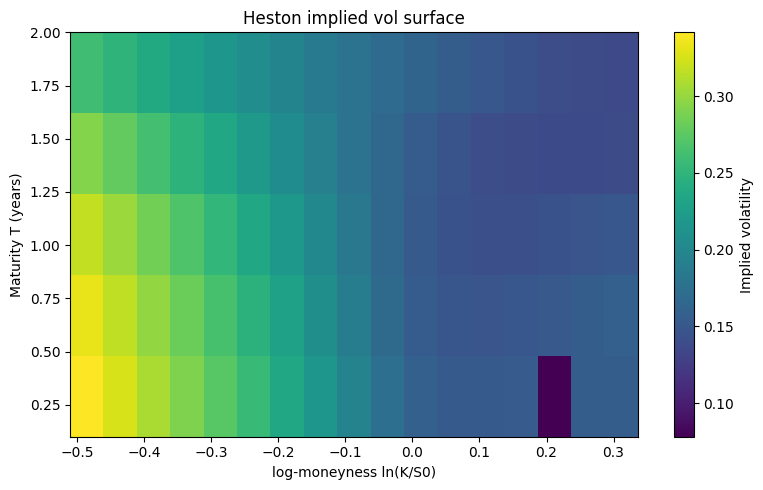

In [215]:
Ks, Ts, iv, prices, fig, ax = plot_iv_surface_heatmap(
    price_fn=heston_fft_call_price,
    S0=100.0,
    strikes=np.linspace(60, 140, 17),
    maturities=np.array([0.1, 0.25, 0.5, 1.0, 2.0]),
    r=0.01, q=0.00, params=hp,
    moneyness="logm", annotate=False
)

In [216]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # nécessaire pour projection 3D

def plot_iv_surface_3d(price_fn, S0, strikes, maturities, r=0.0, q=0.0, params=None,
                       title="Heston implied volatility surface", moneyness="logm",
                       cmap="viridis", elev=25, azim=-135):
    """
    Calcule et trace la surface de volatilité implicite 3D à partir d'un modèle Heston.

    Parameters
    ----------
    price_fn : callable(S0, K, T, r, q, params) -> call price
    S0, strikes, maturities, r, q, params : usuels
    title : titre du graphe
    moneyness : "strike" ou "logm" (log-moneyness ln(K/S0))
    cmap : colormap matplotlib
    elev, azim : angles de vue 3D

    Returns
    -------
    Ks, Ts, iv, prices, fig, ax
    """


    Ks = np.asarray(strikes, dtype=float)
    Ts = np.asarray(maturities, dtype=float)
    Ks, Ts, iv, prices = compute_iv_surface(price_fn, S0, Ks, Ts, r=r, q=q, params=params)

    # grille 2D pour surface
    K_grid, T_grid = np.meshgrid(Ks, Ts)
    if moneyness == "logm":
        X = np.log(K_grid / S0)
        xlabel = "log-moneyness ln(K/S0)"
    else:
        X = K_grid
        xlabel = "Strike K"

    Y = T_grid
    Z = iv

    fig = plt.figure(figsize=(9, 6))
    ax = fig.add_subplot(111, projection="3d")
    surf = ax.plot_surface(X, Y, Z, cmap=cmap, edgecolor="none", alpha=0.9)

    ax.set_xlabel(xlabel)
    ax.set_ylabel("Maturity T (years)")
    ax.set_zlabel("Implied volatility")
    ax.set_title(title)

    ax.view_init(elev=elev, azim=azim)
    fig.colorbar(surf, ax=ax, shrink=0.6, label="Implied vol")
    plt.tight_layout()
    plt.show()

    return Ks, Ts, iv, prices, fig, ax

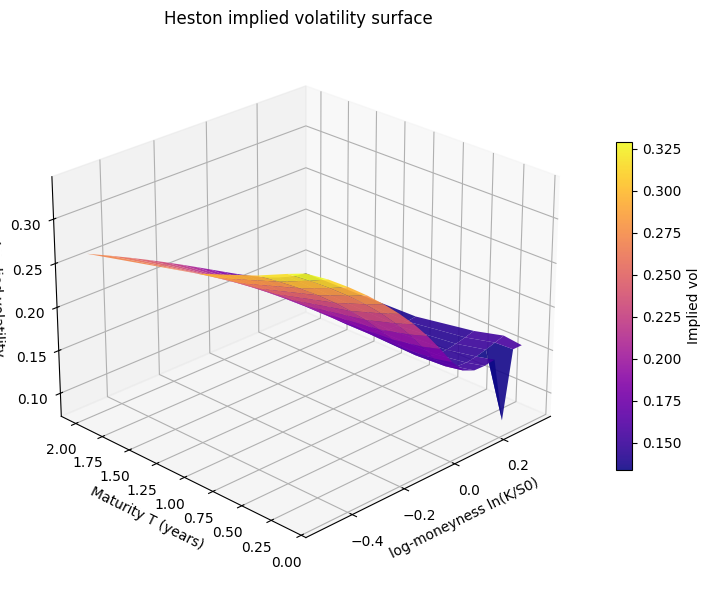

In [217]:
Ks, Ts, iv, prices, fig, ax = plot_iv_surface_3d(
    price_fn=heston_fft_call_price,
    S0=100.0,
    strikes=np.linspace(60, 140, 17),
    maturities=np.array([0.1, 0.25, 0.5, 1.0, 2.0]),
    r=0.01, q=0.00, params=hp,
    moneyness="logm", cmap="plasma"
)

In [218]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def compare_iv_surface_3d(price_fn_heston, S0, strikes, maturities, r=0.0, q=0.0,
                          params_heston=None, vol_bs=0.2,
                          title="Heston vs Black–Scholes implied volatility surfaces",
                          moneyness="logm", cmap_heston="plasma", cmap_bs="viridis",
                          elev=25, azim=-135):
    """
    Compare la surface de volatilité implicite du modèle Heston à celle de Black–Scholes (vol constante).

    Parameters
    ----------
    price_fn_heston : callable(S0, K, T, r, q, params) -> prix du CALL (modèle de Heston)
    S0, strikes, maturities, r, q : floats
    params_heston : paramètres Heston (instance)
    vol_bs : volatilité constante utilisée pour le modèle Black–Scholes
    moneyness : "strike" ou "logm" pour l’axe X
    cmap_heston, cmap_bs : colormaps
    elev, azim : angles de vue du graphique 3D

    Returns
    -------
    (Ks, Ts, iv_heston, iv_bs, fig)
    """


    # 1) Grilles
    Ks = np.asarray(strikes, dtype=float)
    Ts = np.asarray(maturities, dtype=float)

    # 2) Surface Heston
    Ks, Ts, iv_heston, _ = compute_iv_surface(price_fn_heston, S0, Ks, Ts, r=r, q=q, params=params_heston)

    # 3) Surface Black–Scholes (vol constante)
    iv_bs = np.full_like(iv_heston, vol_bs)

    # 4) Préparer les grilles 2D
    K_grid, T_grid = np.meshgrid(Ks, Ts)
    if moneyness == "logm":
        X = np.log(K_grid / S0)
        xlabel = "log-moneyness ln(K/S0)"
    else:
        X = K_grid
        xlabel = "Strike K"

    Y = T_grid

    # 5) Graphiques côte à côte
    fig = plt.figure(figsize=(13, 5))
    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    ax2 = fig.add_subplot(1, 2, 2, projection="3d")

    surf1 = ax1.plot_surface(X, Y, iv_heston, cmap=cmap_heston, edgecolor="none", alpha=0.9)
    surf2 = ax2.plot_surface(X, Y, iv_bs, cmap=cmap_bs, edgecolor="none", alpha=0.9)

    for ax, title_part in zip([ax1, ax2], ["Heston", "Black–Scholes (constant vol)"]):
        ax.set_xlabel(xlabel)
        ax.set_ylabel("Maturity T (years)")
        ax.set_zlabel("Implied volatility")
        ax.set_title(title_part)
        ax.view_init(elev=elev, azim=azim)

    fig.suptitle(title, fontsize=13)
    plt.tight_layout()
    plt.show()

    return Ks, Ts, iv_heston, iv_bs, fig

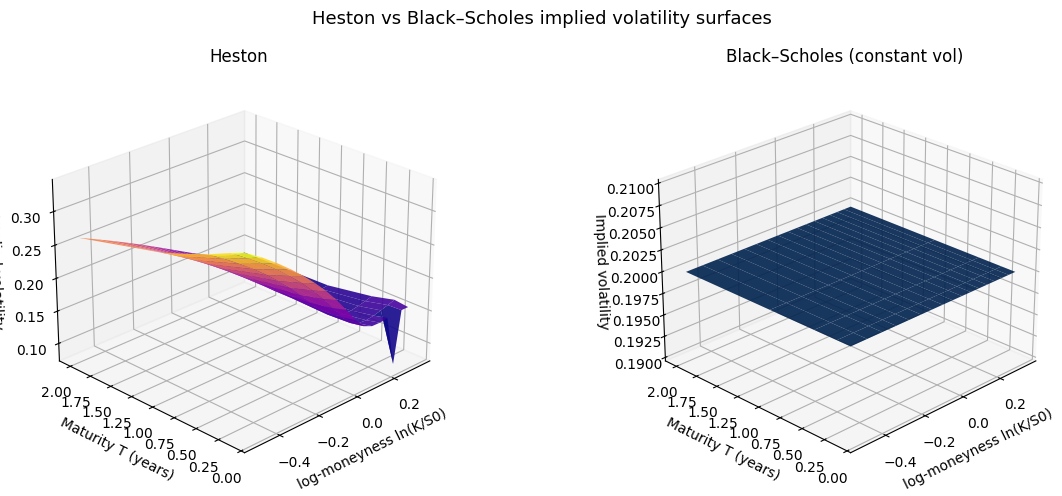

In [219]:
Ks, Ts, iv_heston, iv_bs, fig = compare_iv_surface_3d(
    price_fn_heston=heston_fft_call_price,
    S0=100.0,
    strikes=np.linspace(60, 140, 17),
    maturities=np.array([0.1, 0.25, 0.5, 1.0, 2.0]),
    r=0.01, q=0.00,
    params_heston=hp,         # ton instance HestonParams
    vol_bs=0.2,               # volatilité constante de référence
    moneyness="logm",
    cmap_heston="plasma",
    cmap_bs="cividis"
)

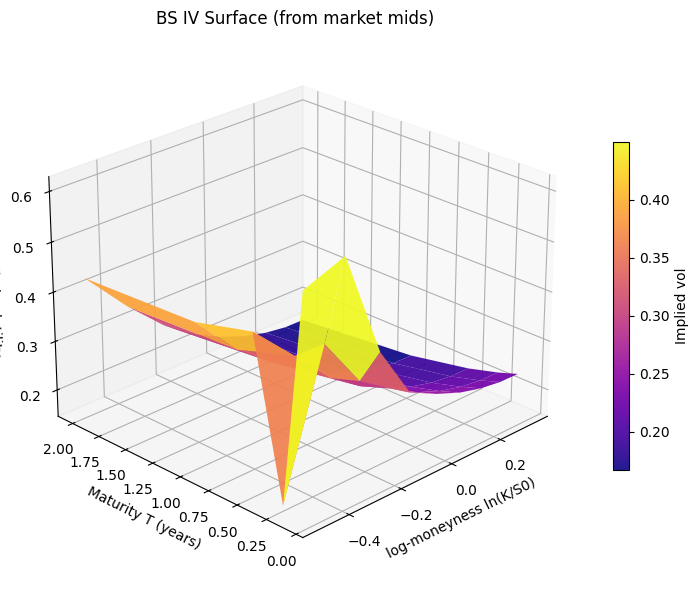

(<Figure size 900x600 with 2 Axes>,
 <Axes3D: title={'center': 'BS IV Surface (from market mids)'}, xlabel='log-moneyness ln(K/S0)', ylabel='Maturity T (years)', zlabel='Implied volatility'>)

In [220]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math

# ---------- Black–Scholes utils ----------
def _ncdf(x): return 0.5*(1.0 + math.erf(x/math.sqrt(2.0)))

def _bs_call(S0, K, T, r, q, vol):
    if T <= 0 or vol <= 0:
        return max(0.0, S0*math.exp(-q*T) - K*math.exp(-r*T))
    d1 = (math.log(S0/K) + (r - q + 0.5*vol*vol)*T)/(vol*math.sqrt(T))
    d2 = d1 - vol*math.sqrt(T)
    return S0*math.exp(-q*T)*_ncdf(d1) - K*math.exp(-r*T)*_ncdf(d2)

def _iv_bisect_call(price, S0, K, T, r=0.0, q=0.0, tol=1e-8, max_iter=100):
    lo, hi = 1e-6, 5.0
    intrinsic = max(0.0, S0*math.exp(-q*T) - K*math.exp(-r*T))
    cap = S0*math.exp(-q*T) - 1e-14
    price = min(max(price, intrinsic), cap)
    f_lo  = _bs_call(S0, K, T, r, q, lo) - price
    f_hi  = _bs_call(S0, K, T, r, q, hi) - price
    if f_lo * f_hi > 0:
        hi = 10.0
        f_hi = _bs_call(S0, K, T, r, q, hi) - price
        if f_lo * f_hi > 0:
            return float('nan')
    for _ in range(max_iter):
        mid = 0.5*(lo + hi)
        f_mid = _bs_call(S0, K, T, r, q, mid) - price
        if abs(f_mid) < tol or (hi - lo) < tol: return mid
        if f_lo * f_mid <= 0:
            hi, f_hi = mid, f_mid
        else:
            lo, f_lo = mid, f_mid
    return 0.5*(lo + hi)

# ---------- Build IV surface from market chain ----------
def iv_surface_from_chain_csv(csv_path, S0, r=0.0, q=0.0):
    """
    csv_path doit contenir colonnes: T, K, call_mid
    Retourne Ks, Ts, IV (shape (len(Ts), len(Ks)))
    """
    df = pd.read_csv(csv_path)
    if "iv" not in df.columns:
        ivs = []
        for _, row in df.iterrows():
            ivs.append(_iv_bisect_call(row["call_mid"], S0, row["K"], row["T"], r, q))
        df["iv"] = ivs
    Ks = np.sort(df["K"].unique())
    Ts = np.sort(df["T"].unique())
    IV = df.pivot(index="T", columns="K", values="iv").reindex(index=Ts, columns=Ks).values
    return Ks, Ts, IV

# ---------- Plotter ----------
def plot_iv_surface_3d_from_arrays(Ks, Ts, IV, S0=100.0, use_logm=True,
                                   title="Implied Volatility Surface",
                                   cmap="plasma", elev=25, azim=-135,
                                   figsize=(9,6), savepath=None):
    Ks = np.asarray(Ks, dtype=float)
    Ts = np.asarray(Ts, dtype=float)
    IV = np.asarray(IV, dtype=float)
    assert IV.shape == (Ts.size, Ks.size), "IV doit être (len(Ts), len(Ks))"

    K_grid, T_grid = np.meshgrid(Ks, Ts)
    if use_logm:
        X = np.log(K_grid/float(S0)); xlabel = "log-moneyness ln(K/S0)"
    else:
        X = K_grid; xlabel = "Strike K"

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection="3d")
    surf = ax.plot_surface(X, T_grid, IV, cmap=cmap, edgecolor="none", alpha=0.92)
    ax.set_xlabel(xlabel); ax.set_ylabel("Maturity T (years)"); ax.set_zlabel("Implied volatility")
    ax.set_title(title); ax.view_init(elev=elev, azim=azim)
    fig.colorbar(surf, ax=ax, shrink=0.6, label="Implied vol")
    plt.tight_layout()
    if savepath: plt.savefig(savepath, dpi=160)
    plt.show()
    return fig, ax

# ---------- Run ----------
S0, r, q = 100.0, 0.01, 0.00
Ks, Ts, IV = iv_surface_from_chain_csv("market_option_chain.csv", S0=S0, r=r, q=q)
plot_iv_surface_3d_from_arrays(Ks, Ts, IV, S0=S0, title="BS IV Surface (from market mids)")


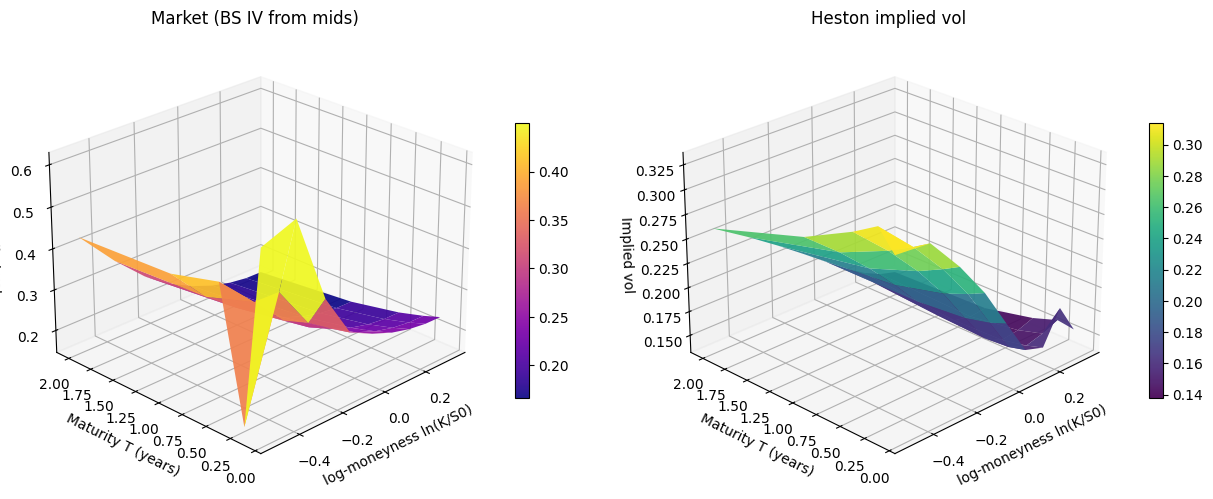

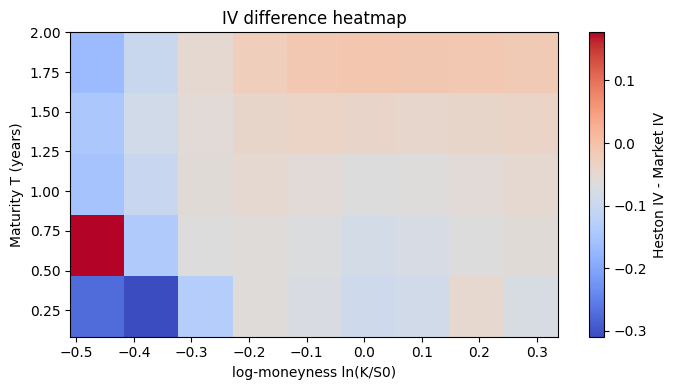

{'Ks': array([ 60.,  70.,  80.,  90., 100., 110., 120., 130., 140.]),
 'Ts': array([0.08333333, 0.25      , 0.5       , 1.        , 2.        ]),
 'IV_market': array([[0.58763741, 0.61908387, 0.40691415, 0.29967172, 0.27175791,
         0.25170458, 0.23976406, 0.23394442, 0.23315525],
        [0.15625097, 0.43596385, 0.33273489, 0.29037907, 0.25777167,
         0.23757179, 0.22566211, 0.2198905 , 0.21903625],
        [0.46984156, 0.38740378, 0.31246927, 0.26867951, 0.24094971,
         0.22022945, 0.20802263, 0.2025062 , 0.20178432],
        [0.43873513, 0.34908731, 0.29259388, 0.24883225, 0.21662657,
         0.19632887, 0.18458206, 0.17882423, 0.17792702],
        [0.42828426, 0.33698928, 0.26881958, 0.22337296, 0.19375644,
         0.17342927, 0.16149057, 0.15528759, 0.15462827]]),
 'IV_heston': array([[0.31250094, 0.30953501, 0.27438966, 0.23727601, 0.19604913,
         0.15912612, 0.15275098, 0.1860056 , 0.15625097],
        [0.33312414, 0.29922738, 0.26509862, 0.22912123, 0.18948

In [221]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
from dataclasses import dataclass


import numpy as np
import pandas as pd

# ---------------- BS utils ----------------
def _ncdf(x): return 0.5*(1.0 + math.erf(x/math.sqrt(2.0)))

def _bs_call(S0, K, T, r, q, vol):
    if T <= 0 or vol <= 0:
        return max(0.0, S0*math.exp(-q*T) - K*math.exp(-r*T))
    d1 = (math.log(S0/K) + (r - q + 0.5*vol*vol)*T)/(vol*math.sqrt(T))
    d2 = d1 - vol*math.sqrt(T)
    return S0*math.exp(-q*T)*_ncdf(d1) - K*math.exp(-r*T)*_ncdf(d2)

def _iv_bisect_call(price, S0, K, T, r=0.0, q=0.0, tol=1e-8, max_iter=100):
    lo, hi = 1e-6, 5.0
    intrinsic = max(0.0, S0*math.exp(-q*T) - K*math.exp(-r*T))
    cap = S0*math.exp(-q*T) - 1e-14
    price = min(max(price, intrinsic), cap)
    f_lo  = _bs_call(S0, K, T, r, q, lo) - price
    f_hi  = _bs_call(S0, K, T, r, q, hi) - price
    if f_lo * f_hi > 0:
        hi = 10.0
        f_hi = _bs_call(S0, K, T, r, q, hi) - price
        if f_lo * f_hi > 0: return float('nan')
    for _ in range(max_iter):
        mid = 0.5*(lo + hi)
        f_mid = _bs_call(S0, K, T, r, q, mid) - price
        if abs(f_mid) < tol or (hi - lo) < tol: return mid
        if f_lo * f_mid <= 0: hi, f_hi = mid, f_mid
        else:                 lo, f_lo = mid, f_mid
    return 0.5*(lo + hi)

# ---------------- Heston pricer (P1,P2) ----------------
@dataclass(frozen=True)
class HestonParams:
    kappa: float
    theta: float
    sigma: float
    rho: float
    v0: float

def _heston_cf(u, T, S0, r, q, p: HestonParams):
    i = 1j
    x0 = math.log(S0)
    a  = p.kappa * p.theta
    b  = p.kappa - p.rho * p.sigma * i * u
    d  = np.sqrt(b*b + (p.sigma**2)*(i*u + u*u))
    g  = (b - d)/(b + d)
    e  = np.exp(-d*T)
    C  = i*u*(x0 + (r - q)*T) + (a/(p.sigma**2))*((b - d)*T - 2*np.log((1 - g*e)/(1 - g)))
    D  = ((b - d)/(p.sigma**2))*((1 - e)/(1 - g*e))
    return np.exp(C + D*p.v0)

def _integrand_P2(u, T, S0, K, r, q, params):
    u = np.asarray(u, dtype=float)
    logK = np.log(K)
    cf   = _heston_cf(u, T, S0, r, q, params)       # φ(u)
    with np.errstate(divide='ignore', invalid='ignore'):
        z = np.exp(-1j*u*logK) * cf / (1j*u)
    z = np.where(u == 0.0, 0.0, z)                  # limite en 0
    return np.real(z)

def _integrand_P1(u, T, S0, K, r, q, params):
    u = np.asarray(u, dtype=float)
    logK = np.log(K)
    phi_mi = _heston_cf(-1j, T, S0, r, q, params)   # φ(-i)
    cf = _heston_cf(u - 1j, T, S0, r, q, params)    # φ(u - i)
    with np.errstate(divide='ignore', invalid='ignore'):
        z = np.exp(-1j*u*logK) * cf / (1j*u*phi_mi)
    z = np.where(u == 0.0, 0.0, z)                  # limite en 0
    return np.real(z)

def _simpson_integral(f, u_max, N, *args):
    # Simpson sur [eps, u_max], sans u=0
    if N % 2 == 1:
        N += 1
    eps = 1e-8
    h = (u_max - eps) / N
    u = np.linspace(eps, u_max, N+1)
    y = f(u, *args)
    S = y[0] + y[-1] + 4.0*np.sum(y[1:-1:2]) + 2.0*np.sum(y[2:-2:2])
    return (h/3.0)*S

def heston_call_price(S0, K, T, r, q, params, u_max=200.0, N=4000):
    P1 = 0.5 + (1.0/np.pi)*_simpson_integral(_integrand_P1, u_max, N, T, S0, K, r, q, params)
    P2 = 0.5 + (1.0/np.pi)*_simpson_integral(_integrand_P2, u_max, N, T, S0, K, r, q, params)
    return S0*np.exp(-q*T)*P1 - K*np.exp(-r*T)*P2

# ---------------- Surfaces ----------------
def _iv_surface_from_chain(csv_path, S0, r=0.0, q=0.0):
    df = pd.read_csv(csv_path)
    ivs = []
    for _, row in df.iterrows():
        ivs.append(_iv_bisect_call(row["call_mid"], S0, row["K"], row["T"], r, q))
    df["iv"] = ivs
    Ks = np.sort(df["K"].unique())
    Ts = np.sort(df["T"].unique())
    IV = df.pivot(index="T", columns="K", values="iv").reindex(index=Ts, columns=Ks).values
    return Ks, Ts, IV

def _heston_iv_surface_on_grid(S0, Ks, Ts, r, q, p: HestonParams):
    IV = np.empty((Ts.size, Ks.size))
    for i, T in enumerate(Ts):
        for j, K in enumerate(Ks):
            price = heston_call_price(S0, K, T, r, q, p)
            IV[i, j] = _iv_bisect_call(price, S0, K, T, r, q)
    return IV

# ---------------- Comparaison et plots ----------------
def compare_market_vs_heston_iv_3d(chain_csv, S0, r, q, heston_params: HestonParams,
                                   use_logm=True, elev=25, azim=-135, cmap1="plasma", cmap2="viridis"):
    Ks, Ts, IV_mkt = _iv_surface_from_chain(chain_csv, S0=S0, r=r, q=q)
    IV_hes = _heston_iv_surface_on_grid(S0, Ks, Ts, r, q, heston_params)

    K_grid, T_grid = np.meshgrid(Ks, Ts)
    X = np.log(K_grid/S0) if use_logm else K_grid
    xlabel = "log-moneyness ln(K/S0)" if use_logm else "Strike K"

    fig = plt.figure(figsize=(13, 5))
    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    ax2 = fig.add_subplot(1, 2, 2, projection="3d")
    s1 = ax1.plot_surface(X, T_grid, IV_mkt, cmap=cmap1, edgecolor="none", alpha=0.92)
    s2 = ax2.plot_surface(X, T_grid, IV_hes, cmap=cmap2, edgecolor="none", alpha=0.92)
    for ax, ttl in [(ax1, "Market (BS IV from mids)"), (ax2, "Heston implied vol")]:
        ax.set_xlabel(xlabel); ax.set_ylabel("Maturity T (years)"); ax.set_zlabel("Implied vol")
        ax.set_title(ttl); ax.view_init(elev=elev, azim=azim)
    fig.colorbar(s1, ax=ax1, shrink=0.6); fig.colorbar(s2, ax=ax2, shrink=0.6)
    plt.tight_layout(); plt.show()

    diff = IV_hes - IV_mkt
    plt.figure(figsize=(7,4))
    extent = [X.min(), X.max(), Ts.min(), Ts.max()]
    plt.imshow(diff, origin="lower", aspect="auto", extent=extent, cmap="coolwarm")
    plt.colorbar(label="Heston IV - Market IV")
    plt.xlabel(xlabel); plt.ylabel("Maturity T (years)"); plt.title("IV difference heatmap")
    plt.tight_layout(); plt.show()

    return {"Ks": Ks, "Ts": Ts, "IV_market": IV_mkt, "IV_heston": IV_hes, "IV_diff": diff}

# ---------------- Example run ----------------
hp = HestonParams(kappa=1.5, theta=0.04, sigma=0.5, rho=-0.7, v0=0.04)
compare_market_vs_heston_iv_3d("market_option_chain.csv", S0=100.0, r=0.01, q=0.00, heston_params=hp)
